In [107]:
import numpy as np
import matplotlib.pyplot as plt
import json
from collections import Counter


import sys
sys.path.append('../')
from phase.input_output import PhaseData
from phase.qc import OutlierDetector

In [108]:
data_dir = '../../DATA/ssc.hg38'
#phase_name = 'X'
phase_name = None
#phase_name = 'noDEL'

colors = ['#4db6acff', '#ef6c00ff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]

In [109]:
phase_data = PhaseData(data_dir, phase_name)
sibpairs = phase_data.get_sibpairs()
print('sibpairs', len(sibpairs))

crossovers = phase_data.get_crossovers()
print('crossovers', len(crossovers))

sibpairs 1933
crossovers 289575


In [110]:
crossover_lengths = np.array([co['end_pos']-co['start_pos'] for co in crossovers])
is_mat = np.array([co['is_mat'] for co in crossovers])
is_hts = np.array([co['is_hts'] for co in crossovers])

In [111]:
mat_crossovers = np.array([x['maternal_crossovers'] for x in sibpairs if x['is_fully_phased']])
pat_crossovers = np.array([x['paternal_crossovers'] for x in sibpairs if x['is_fully_phased']])

is_ibd_outlier = np.array([x['is_ibd_outlier'] for x in sibpairs if x['is_fully_phased']])
is_outlier = np.array([x['is_crossover_outlier'] for x in sibpairs if x['is_fully_phased']])

print('outliers', np.sum(is_outlier))

x_min, x_max = np.min(mat_crossovers[~is_ibd_outlier])-5, np.max(mat_crossovers[~is_ibd_outlier])+5
y_min, y_max = np.min(pat_crossovers[~is_ibd_outlier])-5, np.max(pat_crossovers[~is_ibd_outlier])+5


outliers 7


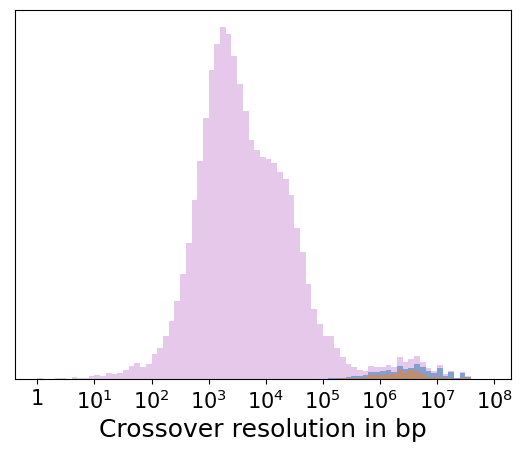

In [112]:
plt.hist(np.log10(crossover_lengths), 
         alpha=0.5, bins=np.arange(0, 8, 0.1), color=colors[4])
plt.hist(np.log10(crossover_lengths[is_hts & is_mat]), 
         alpha=0.5, bins=np.arange(0, 8, 0.1))
plt.hist(np.log10(crossover_lengths[is_hts & ~is_mat]), 
         alpha=0.5, bins=np.arange(0, 8, 0.1))

plt.xlabel('Crossover resolution in bp', fontsize=18)
plt.xticks(np.arange(0, 9), ['1' if i==0 else '$10^{%d}$' % i for i in np.arange(0, 9)], fontsize=15)
plt.yticks([])
plt.show()

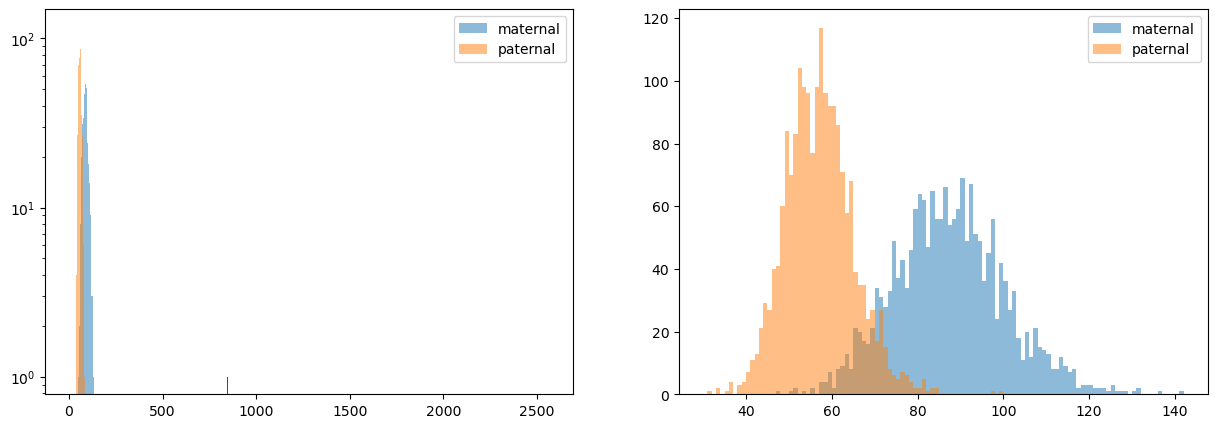

In [113]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(mat_crossovers, bins=np.arange(max(x_max, y_max)), alpha=0.5, label='maternal', log=True)
plt.hist(pat_crossovers, bins=np.arange(max(x_max, y_max)), alpha=0.5, label='paternal', log=True)
plt.hist(mat_crossovers[is_outlier], bins=np.arange(max(x_max, y_max)), color='red', log=True)
plt.hist(pat_crossovers[is_outlier], bins=np.arange(max(x_max, y_max)), color='red', log=True)
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(mat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1), 
         alpha=0.5, label='maternal')
plt.hist(pat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1), 
         alpha=0.5, label='paternal')
plt.legend()
plt.show()

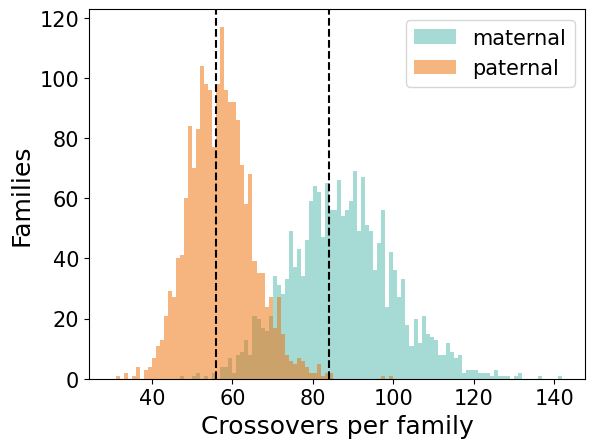

In [121]:
plt.hist(mat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1, 1), 
         alpha=0.5, label='maternal', color=colors[0])
plt.hist(pat_crossovers[~is_outlier], bins=np.arange(np.min(pat_crossovers[~is_outlier])-1, np.max(mat_crossovers[~is_outlier])+1, 1), 
         alpha=0.5, label='paternal', color=colors[1])
plt.legend(fontsize=15)
plt.xlabel('Crossovers per family', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Families', fontsize=18)
plt.yticks(fontsize=15)

if phase_name is None:
    plt.axvline(84, color='black', linestyle='--')
    plt.axvline(56, color='black', linestyle='--')

plt.savefig('../plots/crossover_count.png', bbox_inches="tight")


In [115]:
print(np.median(mat_crossovers[~is_outlier]))
print(np.median(pat_crossovers[~is_outlier]))

print(np.mean(mat_crossovers[~is_outlier]))
print(np.mean(pat_crossovers[~is_outlier]))

86.0
56.0
86.89818181818181
56.61142857142857


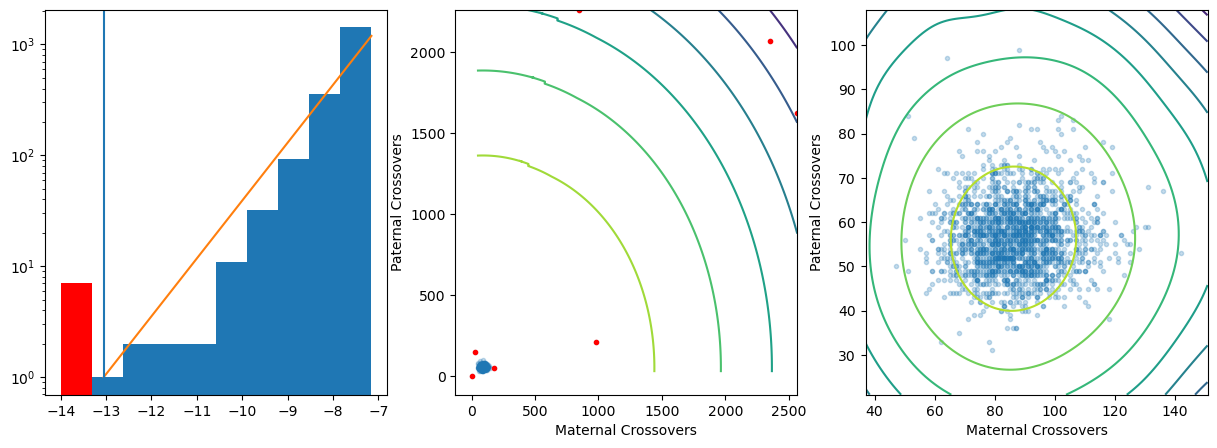

In [116]:
is_way_out = (mat_crossovers > 3*np.median(mat_crossovers)) | (pat_crossovers > 3*np.median(pat_crossovers))
detector = OutlierDetector(mat_crossovers[~is_ibd_outlier & ~is_way_out], 
                           pat_crossovers[~is_ibd_outlier & ~is_way_out], 10)
scores = detector.score_samples(mat_crossovers, pat_crossovers)
outlier_cutoff, m, b = detector.outlier_cutoff, detector.m, detector.b
bins = detector.bins

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(np.clip(scores, min(bins[0], outlier_cutoff), bins[-1]), bins=bins, log=True)
plt.hist(np.clip(scores[is_outlier], min(bins[0], outlier_cutoff), bins[-1]), bins=bins, log=True, color='red')
plt.plot([outlier_cutoff, bins[-1]], [np.exp(m*outlier_cutoff+b), np.exp(m*bins[-1]+b)])
plt.axvline(outlier_cutoff)

plt.subplot(1, 3, 2)
xintervals = np.arange(x_min, x_max)
yintervals = np.arange(y_min, y_max)
gridx, gridy = np.meshgrid(xintervals, yintervals)
predict = detector.score_samples(gridx.flatten(), gridy.flatten())
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

plt.scatter(mat_crossovers, pat_crossovers, marker='.', alpha=0.25)
plt.scatter(mat_crossovers[is_outlier], pat_crossovers[is_outlier], marker='.', color='red')
plt.xlabel('Maternal Crossovers')
plt.ylabel('Paternal Crossovers')

plt.subplot(1, 3, 3)
xintervals = np.arange(np.min(mat_crossovers[~is_outlier])-10, np.max(mat_crossovers[~is_outlier])+10)
yintervals = np.arange(np.min(pat_crossovers[~is_outlier])-10, np.max(pat_crossovers[~is_outlier])+10)
gridx, gridy = np.meshgrid(xintervals, yintervals)
predict = detector.score_samples(gridx.flatten(), gridy.flatten())
plt.contour(xintervals, yintervals, predict.reshape(len(yintervals), len(xintervals)))

plt.scatter(mat_crossovers[~is_outlier], pat_crossovers[~is_outlier], marker='.', alpha=0.25)
plt.xlabel('Maternal Crossovers')
plt.ylabel('Paternal Crossovers')

plt.show()

In [117]:
print(mat_crossovers[is_outlier])
print(pat_crossovers[is_outlier])
print(scores[is_outlier])

[  30  846    0 2563 2352  177  981]
[ 150 2258    0 1623 2072   53  214]
[-3.38153887e+01 -2.64397878e+04 -3.70007586e+01 -4.08034862e+04
 -4.40489362e+04 -1.40039182e+01 -3.37569125e+03]


In [118]:
print(np.max(mat_crossovers[~is_outlier]))

142


In [119]:
print(Counter([x['chrom'] for x in crossovers if x['is_hts']]))

Counter({'19': 1610, '7': 1130, '1': 1104, '17': 948, '2': 739, '16': 673, '12': 617, '8': 564, '9': 563, '15': 528, '22': 460, '11': 416, '10': 364, '3': 307, '5': 305, '6': 303, '20': 209, '4': 187, '18': 182, '13': 113, '14': 86, '21': 51})
